# De belles cartes avec python: mise en pratique

<p class="badges">

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/visualisation/maps.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/visualisation/maps.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/visualisation/maps.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABnotebooks/course/visualisation/maps.ipynb%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=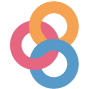" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/visualisation/maps.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/visualisation/maps.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

</p>

</p>

La pratique de la cartographie se fera, dans ce cours, en répliquant des cartes qu’on peut trouver sur
la page de l’*open-data* de la ville de Paris
[ici](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name).

<div class="alert alert-info" role="alert">

Produire de belles cartes demande du temps mais aussi du bon sens. En fonction de la structure des données, certaines représentations sont à éviter voire à exclure. L’excellent guide [disponible ici](https://juliedjidji.github.io/memocarto/semio.html) propose quelques règles et évoque les erreurs à éviter lorsqu’on désire effectuer des
représentations spatiales.

</div>

Ce TP vise à initier:

-   Au module graphique de [geopandas](https://geopandas.org/mapping.html) ainsi qu’aux packages [geoplot](https://residentmario.github.io/geoplot/index.html) et
    [contextily](https://contextily.readthedocs.io/en/latest/intro_guide.html) pour la construction de cartes figées. `geoplot` est construit sur `seaborn` et constitue ainsi une extension des graphiques de base.
-   Au package [folium](https://python-visualization.github.io/folium/) qui est un point d’accès vers la librairie JavaScript [leaflet](https://leafletjs.com/) permettant de produire des cartes interactives

Les données utilisées sont :

-   Un sous-ensemble des données de [paris open data](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name) a été mis à disposition
    sur {{< githubrepo >}} pour faciliter l’import (élimination des colonnes
    qui ne nous servirons pas mais ralentissent l’import)
-   [La localisation précise des stations](https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr)
-   [Arrondissements parisiens](https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr)

Dans la première partie, nous allons utiliser les packages suivants:

In [2]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import geoplot
import matplotlib.pyplot as plt
import folium

<div class="alert alert-danger" role="alert">

Certaines librairies géographiques dépendent de `rtree` qui est parfois difficile à installer. Pour installer `rtree`, le mieux est d’utiliser `anaconda`.

</div>

Installations préalables :

``` python
#| eval: false
#| echo: true
#| include: true

# Sur anaconda
conda install rtree --yes
```

``` python
#| eval: false
#| echo: true
#| include: true

# Sur colab
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas
!pip install geoplot
```

## Première carte avec l’API `matplotlib` de `geopandas`

::: {.cell .markdown}

icon=“fas fa-pencil-alt” %}}

**Exercice 1: Importer les données**

Importer les données de compteurs de vélos en deux temps.

1.  D’abord, les comptages peuvent être trouvés à l’adresse <https://github.com/linogaliana/python-datascientist/raw/master/data/bike.csv>. :warning: Il s’agit de données
    compressées au format `gzip`, il faut donc utiliser l’option `compression`. Nommer cet objet `comptages`.

2.  Importer les données de localisation des compteurs à partir de l’url <https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr>. Nommer cet objet `compteurs`.

3.  Faire attention à deux valeurs aberrantes. Utiliser
    la fonctionalité `str.contains` pour exclure les
    observations contenant *“Bike IN”* ou *“Bike OUT”*
    dans la variable
    `nom_compteur`

In [5]:
compteurs = compteurs.loc[~compteurs["nom_compteur"].str.contains(r"(Bike IN|Bike OUT)")]

/tmp/ipykernel_1622/3602001210.py:1: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


1.  On va également utiliser les données d’arrondissements de la ville de Paris. Importer ces données depuis <https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr>. Nommer cet objet `arrondissements`.

2.  Utiliser la méthode `plot` pour représenter les localisations des compteurs dans l’espace. C’est, on peut l’avouer, peu informatif sans apport extérieur. Il va donc falloir travailler un peu l’esthétique

{{< /box >}}

<div class="alert alert-danger" role="alert">

On serait tenté de faire un *merge* de la base compteurs et comptages. En l’occurrence, il s’agirait d’un produit cartésien puisqu’il s’agit de faire exploser la base spatiale. Avec des données spatiales, c’est souvent une très mauvaise idée. Cela duplique les points, créant des difficultés à représenter les données mais aussi ralentit les calculs. Sauf à utiliser la méthode `dissolve` (qui va agréger *k* fois la même géométrie…), les géométries sont perdues lorsqu’on effectue des `groupby`.

</div>

Maintenant, tout est prêt pour une première carte. `matplotlib` fonctionne selon
le principe des couches. On va de la couche la plus lointaine à celle le plus
en surface. L’exception est lorsqu’on ajoute un fond de carte `contextily` via
`ctx.add_basemap`: on met cet appel en dernier.

::: {.cell .markdown}

icon=“fas fa-pencil-alt” %}}

**Exercice 2: Première carte**

Représenter une carte des `compteurs` avec le fonds de carte des `arrondissements`

-   Faire attention à avoir des arrondissements dont l’intérieur est transparent (argument à utiliser: `facecolor`).
-   Faire des bordures d’arrondissements noires et affichez les compteurs en rouge.
-   Pour obtenir un graphique plus grand, vous pouvez utiliser l’argument `figsize = (10,10)`.
-   Pour les localisations, les points doivent être rouges en étant plus transparent au centre (argument à utiliser: `alpha`)

Vous devriez obtenir cette carte:

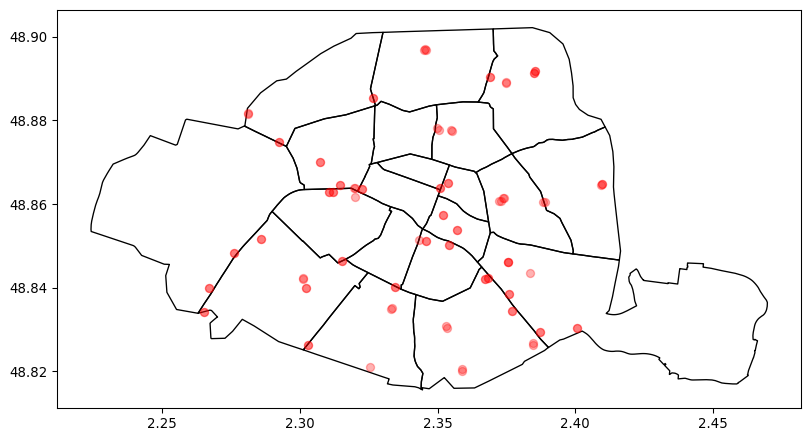

{{< /box >}}

::: {.cell .markdown}

icon=“fas fa-pencil-alt” %}}

**Exercice 3 : Ajouter un fonds de carte avec contextily**

Repartir de la carte précédente.

1.  Utiliser `ctx.add_basemap` pour ajouter un fonds de carte. Pour ne pas afficher les axes, vous pouvez utiliser `ax.set_axis_off()`.

:warning: *Par défaut, `contextily` désire un système de projection (crs) qui est le Web Mercator (epsg: 3857). Il faut changer la valeur de l’argument `crs`.*

:warning: *Avec les versions anciennes des packages, il faut utiliser `.to_string` sur un objet CRS pour qu’il soit reconnu par `contextily`. Sur des versions récentes, la valeur numérique du code EPSG est suffisante.*

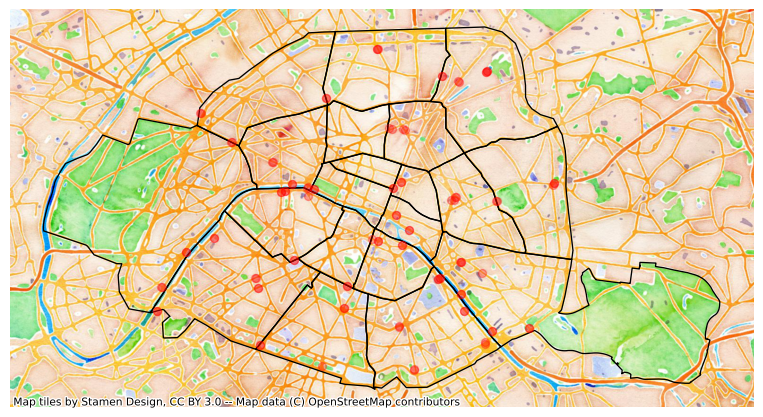

In [11]:
ax.get_figure()

1.  Trouver un fonds de carte plus esthétique, qui permette de visualiser les grands axes, parmi ceux possibles. Pour tester l’esthétique, vous pouvez utiliser [cet url](http://leaflet-extras.github.io/leaflet-providers/preview/index.html). La documentation de référence sur les tuiles disponibles est [ici](https://contextily.readthedocs.io/en/latest/providers_deepdive.html)

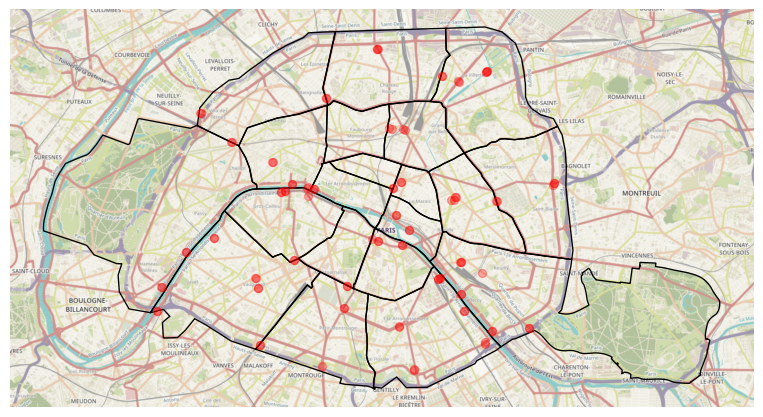

In [13]:
ax.get_figure()

{{< /box >}}

In [14]:
ax.get_figure().savefig("featured.png")

Le principe de la *heatmap* est de construire, à partir d’un nuage de point bidimensionnel, une distribution 2D lissée. La méthode repose sur les estimateurs à noyaux qui sont des méthodes de lissage local.

<div class="alert alert-info" role="alert">

Pour le moment, la fonction `geoplot.kdeplot` n’incorpore pas toutes les fonctionalités de `seaborn.kdeplot`. Pour être en mesure de construire une `heatmap` avec des données pondérées (cf. [cette issue dans le dépôt seaborn](https://github.com/mwaskom/seaborn/issues/1364)), il y a une astuce. Il faut simuler *k* points de valeur 1 autour de la localisation observée. La fonction ci-dessous, qui m’a été bien utile, est pratique

``` python
import numpy as np
def expand_points(shapefile,
                  index_var = "grid_id",
                  weight_var = 'prop',
                  radius_sd = 100,
                  crs = 2154):
    """
    Multiply number of points to be able to have a weighted heatmap
    :param shapefile: Shapefile to consider
    :param index_var: Variable name to set index
    :param weight_var: Variable that should be used
    :param radius_sd: Standard deviation for the radius of the jitter
    :param crs: Projection system that should be used. Recommended option
      is Lambert 93 because points will be jitterized using meters
    :return:
      A geopandas point object with as many points by index as weight
    """

    shpcopy = shapefile
    shpcopy = shpcopy.set_index(index_var)
    shpcopy['npoints'] = np.ceil(shpcopy[weight_var])
    shpcopy['geometry'] = shpcopy['geometry'].centroid
    shpcopy['x'] = shpcopy.geometry.x
    shpcopy['y'] = shpcopy.geometry.y
    shpcopy = shpcopy.to_crs(crs)
    shpcopy = shpcopy.loc[np.repeat(shpcopy.index.values, shpcopy.npoints)]
    shpcopy['x'] = shpcopy['x'] + np.random.normal(0, radius_sd, shpcopy.shape[0])
    shpcopy['y'] = shpcopy['y'] + np.random.normal(0, radius_sd, shpcopy.shape[0])

    gdf = gpd.GeoDataFrame(
        shpcopy,
        geometry = gpd.points_from_xy(shpcopy.x, shpcopy.y),
        crs = crs)

    return gdf
```

</div>

::: {.cell .markdown}

icon=“fas fa-pencil-alt” %}}

**Exercice 4 : Data cleaning avant de pouvoir faire une heatmap**

1.  Calculer le trafic moyen, pour chaque station, entre 7 heures et 10 heures (bornes incluses) et nommer cet objet `df1`. Faire la même chose, en nommant `df2`, pour le trafic entre 17 et 20 heures (bornes incluses)

2.  Nous allons désormais préparer les données de manière à faire une heatmap. Après avoir compris ce que permet de faire la fonction `expand_points` ci-dessus, créer une fonction `explode_data` qui suive les étapes suivantes.

-   Convertir un DataFrame dans le système de projection Lambert 93 (epsg: 2154)
-   Appliquer `expand_points` aux noms de variable adéquats. Vous pouvez fixer la valeur de `radius_sd` à `100`.
-   Reconvertir l’output au format WGS84 (epsg: 4326)

1.  Appliquer cette fonction à `df1` et `df2`

{{< /box >}}

::: {.cell .markdown}

**Exercice 5 : Heatmap, enfin !**

Représenter, pour ces deux moments de la journée, la `heatmap` du trafic de vélo avec `geoplot.kdeplot`. Pour cela :

-   Appliquer la fonction `geoplot.kdeplot` avec comme consignes :
    -   d’utiliser les arguments `shade=True` et `shade_lowest=True` pour colorer l’intérieur des courbes de niveaux obtenues ;
    -   d’utiliser une palette de couleur rouge avec une transparence modérée (`alpha = 0.6`)
    -   d’utiliser l’argument `clip` pour ne pas déborder hors de Paris (en cas de doute, se référer à l’aide de `geoplot.kdeplot`)
    -   L’argument `bw` (pour *bandwidth*) détermine le plus ou moins fort lissage spatial. Vous pouvez partir d’un bandwidth égal à 0.01 et le faire varier pour voir l’effet sur le résultat
-   Ne pas oublier d’ajouter les arrondissements. Avec `geoplot`, il faut utiliser `geoplot.polyplot`.

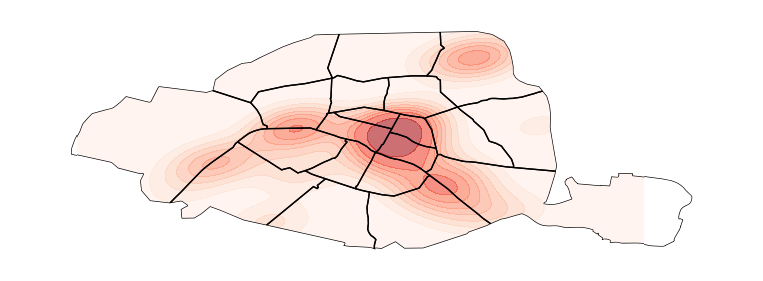

In [20]:
ax.get_figure()

{{< /box >}}

## Des cartes réactives grâce à `folium`

De plus en plus de données de visualisation reposent sur la cartographie réactive. Que ce soit dans l’exploration des données ou dans la représentation finale de résultats, la cartographie réactive est très appréciable.

`folium` offre une interface très flexible et très facile à prendre à main. Les cartes sont construites grâce à la librairie JavaScript `Leaflet.js` mais, sauf si on désire aller loin dans la customisation du résultat, il n’est pas nécessaire d’avoir des notions dans le domaine.

Un objet folium se construit par couche. La première est l’initialisation de la carte. Les couches suivantes sont les éléments à mettre en valeur. L’initialisation de la carte nécessite la définition d’un point central (paramètre `location`) et d’un zoom de départ (`zoom_start`). Plutôt que de fournir manuellement le point central et le zoom on peut :

1.  Déterminer le point central en construisant des colonnes longitudes et latitudes et en prenant la moyenne de celles-ci ;
2.  Utiliser la méthode `fit_bounds` qui cale la carte sur les coins sud-ouest et nord-est. En supposant que la carte s’appelle `m`, on fera `m.fit_bounds([sw, ne])`

Le bout de code suivant permet de calculer le centre de la carte

In [21]:
compteurs['lon'] = compteurs.geometry.x
compteurs['lat'] = compteurs.geometry.y
center = compteurs[['lat', 'lon']].mean().values.tolist()
print(center)

[48.85597387878788, 2.3432656262626264]

Alors que le code suivant permet de calculer les coins:

In [22]:
sw = compteurs[['lat', 'lon']].min().values.tolist()
ne = compteurs[['lat', 'lon']].max().values.tolist()
print(sw, ne)

[48.82009, 2.26526] [48.89696, 2.40966]

<div class="alert alert-warning" role="alert">

Si un fond gris s’affiche, c’est qu’il y a un problème de localisation ou d’accès à internet. Pour le premier cas, cela provient généralement d’un problème de projection ou d’une inversion des longitudes et latitudes.

Les longitudes représentent les *x* (axe ouest-est) et les latitudes *y* (axe sud-nord). De manière contrintuitive, `folium` attend qu’on lui fournisse les données sous la forme `[latitude, longitude]` donc `[y,x]`

</div>

<div class="alert alert-success" role="alert">

**Exercice 6 : Visualiser la localisation des stations**

1.  Calculer le centre `center`de la carte des données `compteurs`. Il s’obtient en agrègeant l’ensemble des géométries, calculant le centroid et récupèrant la valeur sous forme de liste. Avec une logique similaire, calculez les bornes du sud-ouest `sw` et du nord-est `ne` de la carte.

2.  Représenter la localisation des stations en utilisant un zoom optimal.

</div>

{{< rawhtml >}}

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<head> 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.6.0/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-1.12.4.min.js"></script>
 <script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.6.0/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_89bddcff55cb93175e1f38fe4178e269 {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 </style>
 
</head>
<body> 
 
 <div class="folium-map" id="map_89bddcff55cb93175e1f38fe4178e269" ></div>
 
</body>
<script> 
 
 var map_89bddcff55cb93175e1f38fe4178e269 = L.map(
 "map_89bddcff55cb93175e1f38fe4178e269",
 {
 center: [48.85597387878788, 2.3432656262626264],
 crs: L.CRS.EPSG3857,
 zoom: 10,
 zoomControl: true,
 preferCanvas: false,
 }
 );

 

 
 
 var tile_layer_393d4fd0fa71ba117df38b367c5ce5b3 = L.tileLayer(
 "https://stamen-tiles-{s}.a.ssl.fastly.net/toner/{z}/{x}/{y}.png",
 {"attribution": "Map tiles by \u003ca href=\"http://stamen.com\"\u003eStamen Design\u003c/a\u003e, under \u003ca href=\"http://creativecommons.org/licenses/by/3.0\"\u003eCC BY 3.0\u003c/a\u003e. Data by \u0026copy; \u003ca href=\"http://openstreetmap.org\"\u003eOpenStreetMap\u003c/a\u003e, under \u003ca href=\"http://www.openstreetmap.org/copyright\"\u003eODbL\u003c/a\u003e.", "detectRetina": false, "maxNativeZoom": 18, "maxZoom": 18, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 ).addTo(map_89bddcff55cb93175e1f38fe4178e269);
 
 
 var marker_577d0dc0c5f6f278c84f9949918147c3 = L.marker(
 [48.83504, 2.33314],
 {}
 ).addTo(map_89bddcff55cb93175e1f38fe4178e269);
 
 
 var popup_e6acc446c8d04214c9d3a120a3aafd11 = L.popup({"maxWidth": "100%"});

 
 var html_7c60010472db2987f7a8100a300e7958 = $(`<div id="html_7c60010472db2987f7a8100a300e7958" style="width: 100.0%; height: 100.0%;">97 avenue Denfert Rochereau SO-NE</div>`)[0];
 popup_e6acc446c8d04214c9d3a120a3aafd11.setContent(html_7c60010472db2987f7a8100a300e7958);
 

 marker_577d0dc0c5f6f278c84f9949918147c3.bindPopup(popup_e6acc446c8d04214c9d3a120a3aafd11)
 ;

 
 
 
 var marker_8635c088fb214fc456f8efbf9e48a250 = L.marker(
 [48.87773, 2.3506],
 {}
 ).addTo(map_89bddcff55cb93175e1f38fe4178e269);
 
 
 var popup_3a42e68c499dcd1324598d58e85508bb = L.popup({"maxWidth": "100%"});

 
 var html_1a1aeb86c4f8c64bdc147792d7528b3d = $(`<div id="html_1a1aeb86c4f8c64bdc147792d7528b3d" style="width: 100.0%; height: 100.0%;">105 rue La Fayette E-O</div>`)[0];
 popup_3a42e68c499dcd1324598d58e85508bb.setContent(html_1a1aeb86c4f8c64bdc147792d7528b3d);
 

 marker_8635c088fb214fc456f8efbf9e48a250.bindPopup(popup_3a42e68c499dcd1324598d58e85508bb)
 ;

 
 
 
 var marker_395978633df1761fd2d770a902e92336 = L.marker(
 [48.83505, 2.33333],

{{< /rawhtml >}}

::: {.cell .markdown}

**Exercice 7: Représenter les stations**

Faire la même carte, avec des ronds proportionnels au nombre de comptages :

-   Pour le rayon de chaque cercle, vous pouvez appliquer la règle `500*x/max(x)` (règle au doigt mouillé)
-   Vous pouvez réduire la taille des bordures de cercle avec l’option `weight = 1` et fixer la couleur avec `color = 'grey'`
-   (Optionnel) Colorer en rouge les 10 plus grosses stations. L’opacité étant, par défaut, un peu faible, le paramètre `fill_opacity = 0.4` améliore le rendu.
-   (Optionnel) Afficher, en supplément du nom du compteur lorsqu’on clique, la valeur du comptage en revenant à la ligne

{{< /box >}}

La carte obtenue doit ressembler à la suivante:

{{< rawhtml >}}

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<head> 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.6.0/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-1.12.4.min.js"></script>
 <script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.6.0/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_cf7ebbd045ec93d5ce36a4ec7d4e2dd3 {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 </style>
 
</head>
<body> 
 
 <div class="folium-map" id="map_cf7ebbd045ec93d5ce36a4ec7d4e2dd3" ></div>
 
</body>
<script> 
 
 var map_cf7ebbd045ec93d5ce36a4ec7d4e2dd3 = L.map(
 "map_cf7ebbd045ec93d5ce36a4ec7d4e2dd3",
 {
 center: [48.85302174468086, 2.347796297872341],
 crs: L.CRS.EPSG3857,
 zoom: 10,
 zoomControl: true,
 preferCanvas: false,
 }
 );

 

 
 
 var tile_layer_eb5f6444aa9a19dbbd9412ed92ae9b3a = L.tileLayer(
 "https://stamen-tiles-{s}.a.ssl.fastly.net/toner/{z}/{x}/{y}.png",
 {"attribution": "Map tiles by \u003ca href=\"http://stamen.com\"\u003eStamen Design\u003c/a\u003e, under \u003ca href=\"http://creativecommons.org/licenses/by/3.0\"\u003eCC BY 3.0\u003c/a\u003e. Data by \u0026copy; \u003ca href=\"http://openstreetmap.org\"\u003eOpenStreetMap\u003c/a\u003e, under \u003ca href=\"http://www.openstreetmap.org/copyright\"\u003eODbL\u003c/a\u003e.", "detectRetina": false, "maxNativeZoom": 18, "maxZoom": 18, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 ).addTo(map_cf7ebbd045ec93d5ce36a4ec7d4e2dd3);
 
 
 var circle_5272775391860b6309e636405f2e9439 = L.circle(
 [48.84613, 2.37559],
 {"bubblingMouseEvents": true, "color": "grey", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "green", "fillOpacity": 0.4, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 500.0, "stroke": true, "weight": 1}
 ).addTo(map_cf7ebbd045ec93d5ce36a4ec7d4e2dd3);
 
 
 var popup_d64f28c1b51ebaabb196de3865513941 = L.popup({"maxWidth": "100%"});

 
 var html_aa986525ea2b2046d09eed2f54c80999 = $(`<div id="html_aa986525ea2b2046d09eed2f54c80999" style="width: 100.0%; height: 100.0%;">28 boulevard Diderot O-E: <br> 44.0</div>`)[0];
 popup_d64f28c1b51ebaabb196de3865513941.setContent(html_aa986525ea2b2046d09eed2f54c80999);
 

 circle_5272775391860b6309e636405f2e9439.bindPopup(popup_d64f28c1b51ebaabb196de3865513941)
 ;

 
 
 
 var circle_d4ab14fe5a2d463b4a538bb1cf9527ff = L.circle(
 [48.84613, 2.37559],
 {"bubblingMouseEvents": true, "color": "grey", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "green", "fillOpacity": 0.4, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 500.0, "stroke": true, "weight": 1}
 ).addTo(map_cf7ebbd045ec93d5ce36a4ec7d4e2d

{{< /rawhtml >}}